# Comparing the Virtual Product output with notebook output

Need to test if virtual products is behaving as expected before attempting to scale the analysis using datacube stats.
To generate the virtual product, run `virtual_product_test.py`.


In [1]:
from datacube import Datacube
import numpy as np
import xarray as xr
import dask
from datacube.utils.dask import start_local_dask
import matplotlib.pyplot as plt
import sys

# sys.path.append('../../Scripts')
# from dea_datahandling import load_ard

sys.path.append('../src')
from anomalies import load_ard

In [3]:
client = locals().get('client', None)
if client is not None:
    client.close()
    del client
    
client = start_local_dask(mem_safety_margin = '3Gb', threads_per_worker=4)

display(client)


Client Scheduler: tcp://127.0.0.1:44600 Dashboard: http://127.0.0.1:39441/status,Cluster Workers: 1 Cores: 4 Memory: 30.67 GB


## Load data matching extents of VP 

In [4]:
lat, lon = -33.2, 149.1
buffer = 0.05
time = ('1987', '2010')


In [5]:
dc = Datacube(env='c3-samples')

query = {'lon': (lon - buffer, lon + buffer),
         'lat': (lat - buffer, lat + buffer),
         'time': time,
         'measurements':['nbart_red', 'nbart_nir'],
         'output_crs' :'EPSG:3577',
         'resolution' : (-30, 30),
         'resampling' :{"fmask": "nearest", "*": "average"}}    

In [6]:
ds = load_ard(dc=dc, 
              dask_chunks={'x':150, 'y':150},
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3'],
              ls7_slc_off=False,
              **query)
print(ds)

Loading ga_ls5t_ard_3 data
    Applying pixel quality/cloud mask
    Applying contiguity/missing data mask
Loading ga_ls7e_ard_3 data
    Ignoring SLC-off observations for ls7
    Applying pixel quality/cloud mask
    Applying contiguity/missing data mask
Combining and sorting data
    Returning 787 observations as a dask array
<xarray.Dataset>
Dimensions:    (time: 787, x: 356, y: 411)
Coordinates:
  * y          (y) float64 -3.721e+06 -3.721e+06 ... -3.733e+06 -3.733e+06
  * x          (x) float64 1.573e+06 1.574e+06 1.574e+06 ... 1.584e+06 1.584e+06
  * time       (time) datetime64[ns] 1987-05-29T23:14:05.701791 ... 2010-12-29T23:45:58.889071
Data variables:
    nbart_red  (time, y, x) float32 dask.array<chunksize=(1, 150, 150), meta=np.ndarray>
    nbart_nir  (time, y, x) float32 dask.array<chunksize=(1, 150, 150), meta=np.ndarray>
Attributes:
    crs:      EPSG:3577


## Calculate climatologies

In [7]:
quarter= {'JFM': [1,2,3],
                       'FMA': [2,3,4],
                       'MAM': [3,4,5],
                       'AMJ': [4,5,6],
                       'MJJ': [5,6,7],
                       'JJA': [6,7,8],
                       'JAS': [7,8,9],
                       'ASO': [8,9,10],
                       'SON': [9,10,11],
                       'OND': [10,11,12],
                       'NDJ': [11,12,1],
                       'DJF': [12,1,2],
                      }

def ndvi_clim_mean(data):
#     print(data)
    def attrs_reassign(da, dtype=np.float32):
        da_attr = data.attrs
        da = da.assign_attrs(**da_attr)
        return da
    
    ndvi = xr.Dataset(data_vars={'ndvi': (data.nbart_nir - data.nbart_red) / (data.nbart_nir + data.nbart_red)},
                          coords=data.coords,
                          attrs=dict(crs=data.crs))
#     print(ndvi)
    ndvi_var = []
    for q in quarter:
        ix=ndvi['time.month'].isin(quarter[q])
        ndvi_clim_mean=ndvi.where(ix,drop = True).std(dim='time')   
        ndvi_clim_mean=ndvi_clim_mean.to_array(name=q).drop('variable').squeeze()
        ndvi_var.append(ndvi_clim_mean)

    q_clim_mean = xr.merge(ndvi_var)   

    #assign back attributes
    q_clim_mean.attrs = data.attrs 
    q_clim_mean = q_clim_mean.apply(attrs_reassign, keep_attrs=True)  

    return q_clim_mean

In [8]:
clim = ndvi_clim_mean(ds)
print(clim)

<xarray.Dataset>
Dimensions:  (x: 356, y: 411)
Coordinates:
  * y        (y) float64 -3.721e+06 -3.721e+06 ... -3.733e+06 -3.733e+06
  * x        (x) float64 1.573e+06 1.574e+06 1.574e+06 ... 1.584e+06 1.584e+06
Data variables:
    JFM      (y, x) float32 dask.array<chunksize=(150, 150), meta=np.ndarray>
    FMA      (y, x) float32 dask.array<chunksize=(150, 150), meta=np.ndarray>
    MAM      (y, x) float32 dask.array<chunksize=(150, 150), meta=np.ndarray>
    AMJ      (y, x) float32 dask.array<chunksize=(150, 150), meta=np.ndarray>
    MJJ      (y, x) float32 dask.array<chunksize=(150, 150), meta=np.ndarray>
    JJA      (y, x) float32 dask.array<chunksize=(150, 150), meta=np.ndarray>
    JAS      (y, x) float32 dask.array<chunksize=(150, 150), meta=np.ndarray>
    ASO      (y, x) float32 dask.array<chunksize=(150, 150), meta=np.ndarray>
    SON      (y, x) float32 dask.array<chunksize=(150, 150), meta=np.ndarray>
    OND      (y, x) float32 dask.array<chunksize=(150, 150), meta=np.n

In [9]:
%%time
clim = clim.compute()

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:38786 remote=tcp://127.0.0.1:44600>


CPU times: user 5min 52s, sys: 13.4 s, total: 6min 5s
Wall time: 12min 39s


## Open VP dataset

In [10]:
vp_clim = xr.open_dataset('VP_test_NDVI_climatology_1987_2010_std.nc').squeeze()
print(vp_clim)

<xarray.Dataset>
Dimensions:  (x: 356, y: 411)
Coordinates:
  * y        (y) float64 -3.721e+06 -3.721e+06 ... -3.733e+06 -3.733e+06
  * x        (x) float64 1.573e+06 1.574e+06 1.574e+06 ... 1.584e+06 1.584e+06
    time     datetime64[ns] 1987-01-01
Data variables:
    crs      int32 ...
    JFM      (y, x) float64 ...
    FMA      (y, x) float64 ...
    MAM      (y, x) float64 ...
    AMJ      (y, x) float64 ...
    MJJ      (y, x) float64 ...
    JJA      (y, x) float64 ...
    JAS      (y, x) float64 ...
    ASO      (y, x) float64 ...
    SON      (y, x) float64 ...
    OND      (y, x) float64 ...
    NDJ      (y, x) float64 ...
    DJF      (y, x) float64 ...
Attributes:
    date_created:           2020-02-20T14:19:55.782031
    Conventions:            CF-1.6, ACDD-1.3
    history:                NetCDF-CF file created by datacube version '1.7+2...
    geospatial_bounds:      POLYGON ((149.034045718902 -33.1515343748856,149....
    geospatial_bounds_crs:  EPSG:4326
    geospatial

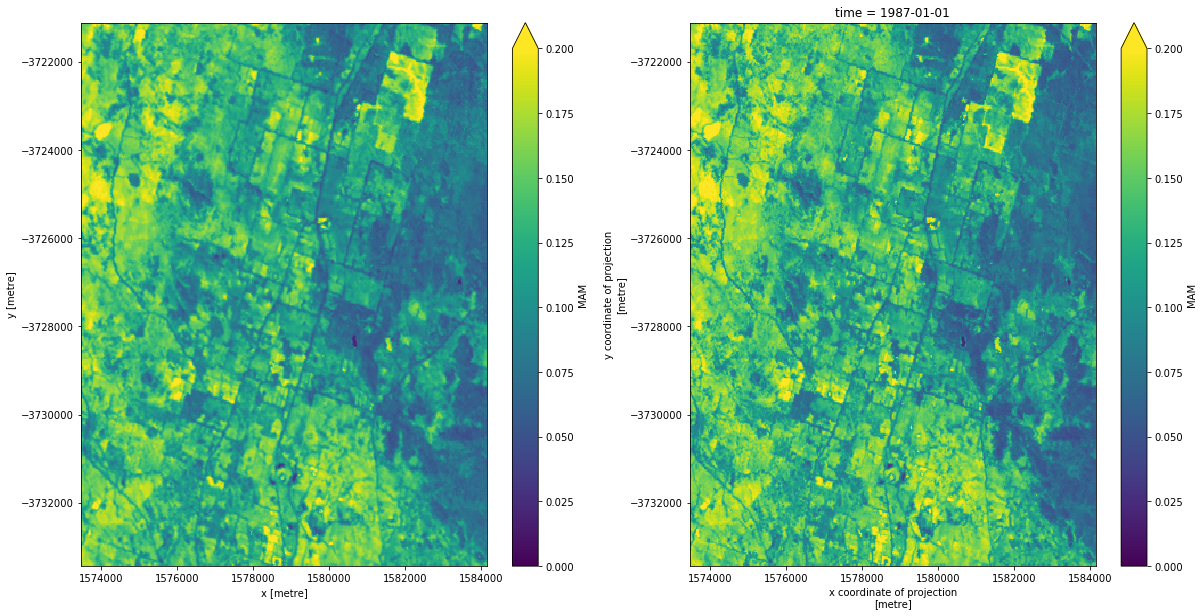

In [22]:
fig = plt.figure(figsize=(20,10))
ax = fig.subplots(nrows=1, ncols=2, sharex='all')
clim.MAM.plot(vmin=0, vmax=0.2, cmap='viridis', ax=ax[0])
vp_clim.MAM.plot(vmin=0, vmax=0.2, cmap='viridis' ,ax=ax[1])

## Calculate deltas

In [11]:
diff_DJF = clim.DJF - vp_clim.DJF
diff_MAM = clim.MAM - vp_clim.MAM
diff_JJA = clim.JJA - vp_clim.JJA
diff_SON = clim.SON - vp_clim.SON

### Plot differences, ideally every pixel will be zero

Minor differences should occur due to resampling differnces and the different ways VP deals with satellite sensor temporal overlap

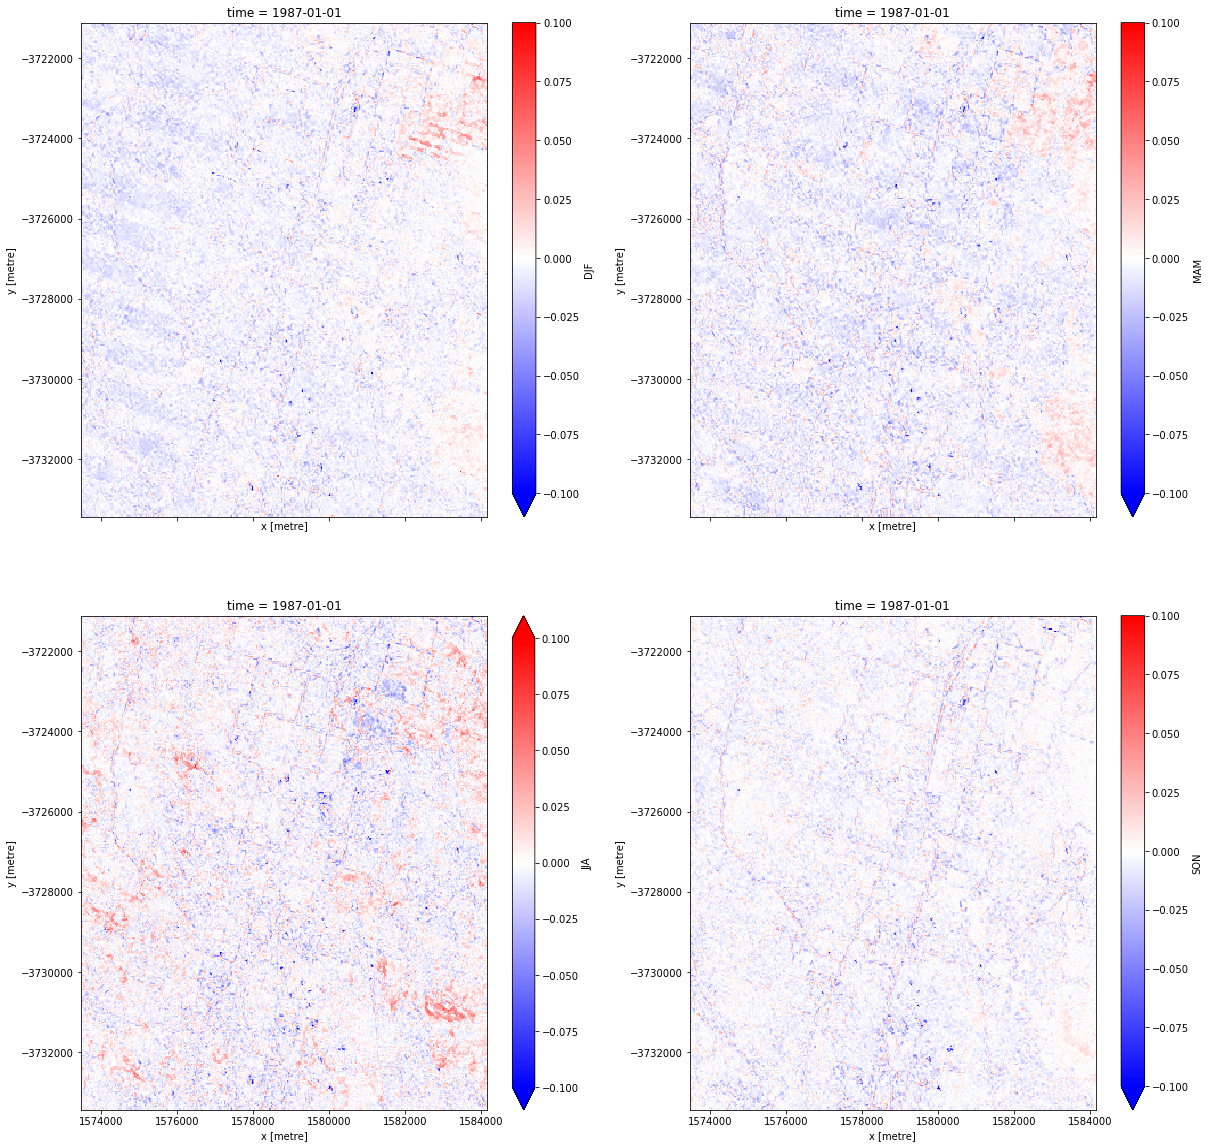

In [13]:
fig = plt.figure(figsize=(20,20))
ax = fig.subplots(nrows=2, ncols=2, sharex='all')
diff_DJF.plot(ax=ax[0,0], cmap='bwr', vmin=-0.1, vmax=0.1)
diff_MAM.plot(ax=ax[0,1], cmap='bwr', vmin=-0.1, vmax=0.1)
diff_JJA.plot(ax=ax[1,0], cmap='bwr', vmin=-0.1, vmax=0.1)
diff_SON.plot(ax=ax[1,1], cmap='bwr', vmin=-0.1, vmax=0.1)